In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

100%|██████████| 149M/149M [00:04<00:00, 33.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Data preprocessing and augmentation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = ImageFolder('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = ImageFolder('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing', transform=data_transforms)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

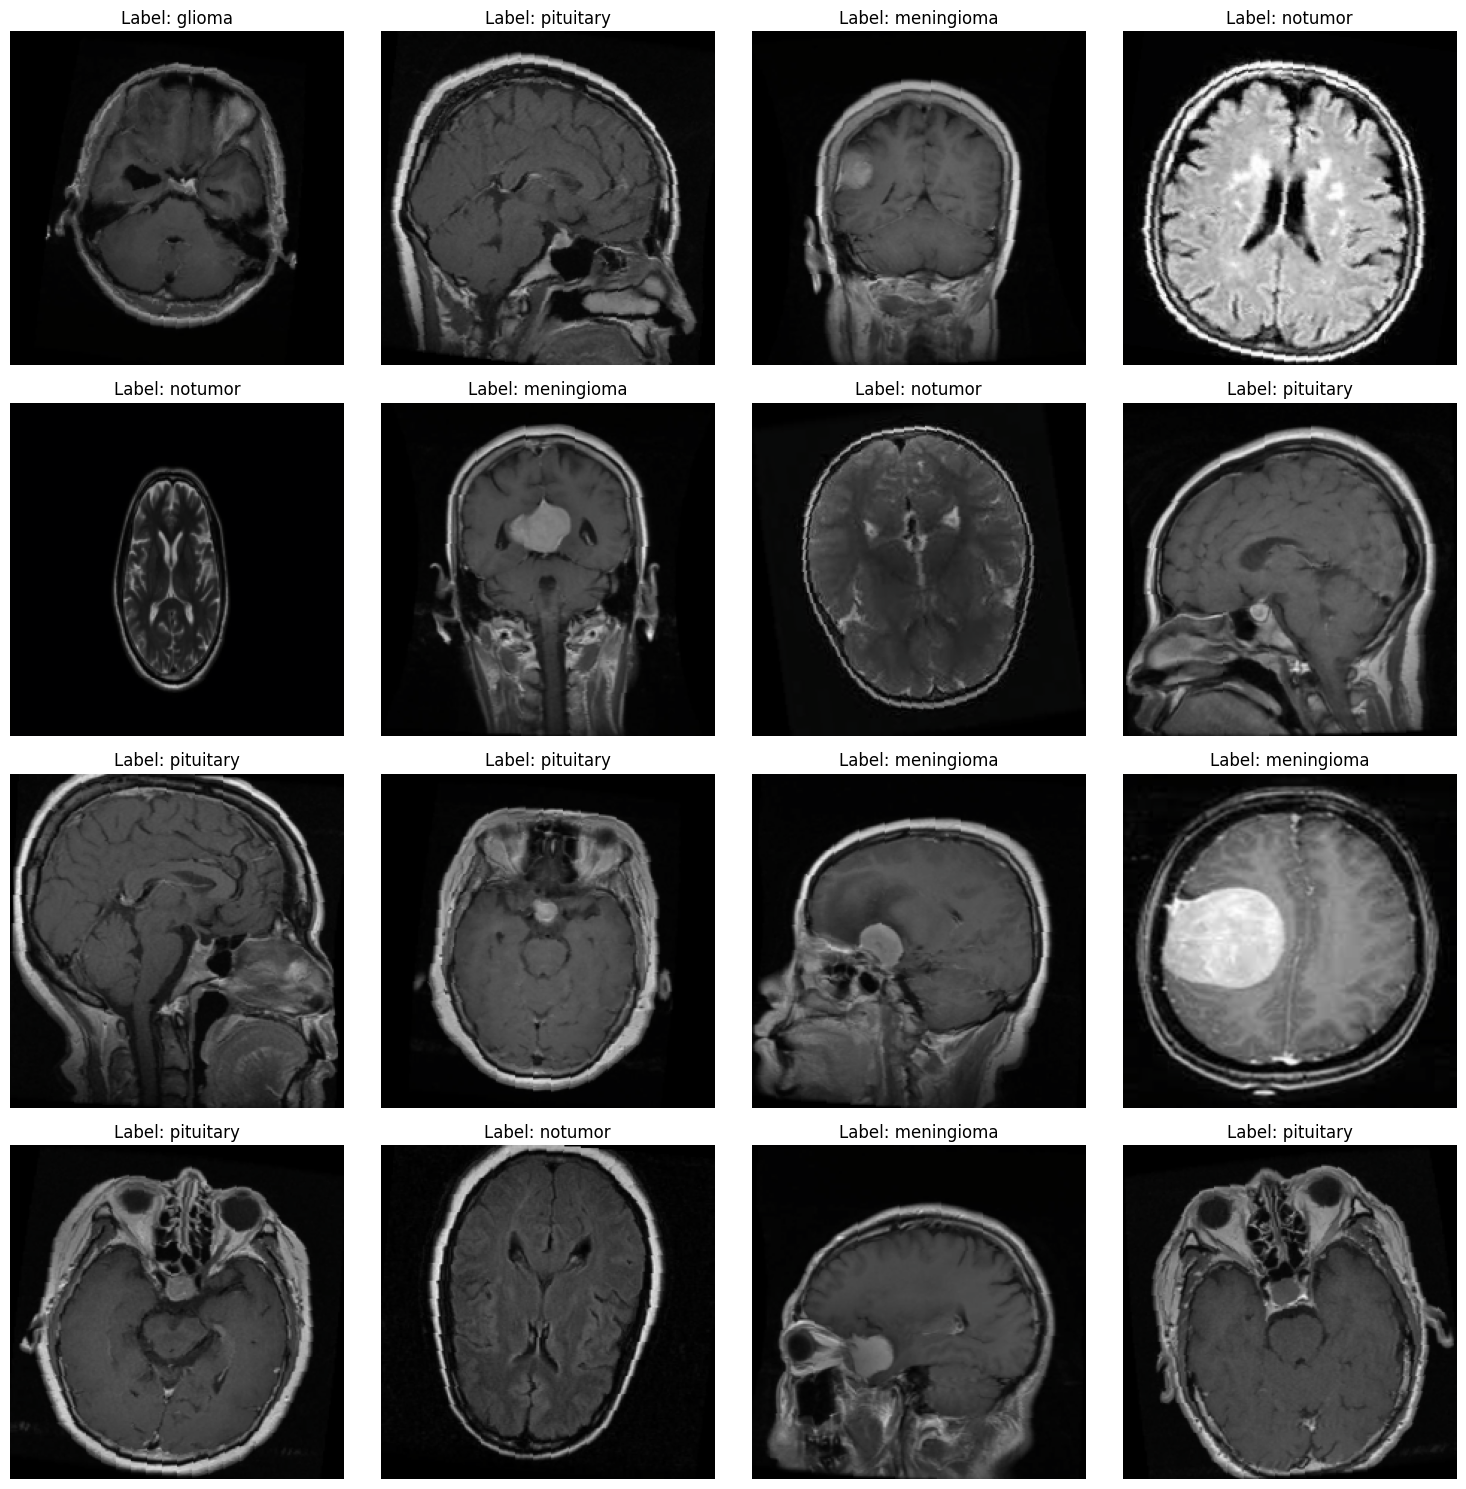

In [ ]:
# Load a batch of images and labels for visualization
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert images to numpy arrays and denormalize
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = (images.numpy().transpose((0, 2, 3, 1)) * std + mean).clip(0, 1)

# Create a grid of images
num_images = len(images)
rows = int(np.ceil(num_images / 4))
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

# Plot images with labels
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_dataset.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
class TumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TumorClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = TumorClassifier(num_classes=4)
# Load a pre-trained ResNet model and modify the classifier
model.to(device)

TumorClassifier(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=100352, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Initialize lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
# Training loop
num_epochs = 20
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}')


    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

Epoch [1/20], Training Loss: 238.8873, Training Accuracy: 77.40%, Validation Loss: 0.5299, Validation Accuracy: 81.39%
Epoch [2/20], Training Loss: 112.0495, Training Accuracy: 87.94%, Validation Loss: 0.2826, Validation Accuracy: 88.48%
Epoch [3/20], Training Loss: 80.5532, Training Accuracy: 91.61%, Validation Loss: 0.2331, Validation Accuracy: 90.85%
Epoch [4/20], Training Loss: 60.0323, Training Accuracy: 93.82%, Validation Loss: 0.1750, Validation Accuracy: 93.82%
Epoch [5/20], Training Loss: 43.6120, Training Accuracy: 95.69%, Validation Loss: 0.1864, Validation Accuracy: 94.43%
Epoch [6/20], Training Loss: 36.4704, Training Accuracy: 96.38%, Validation Loss: 0.1168, Validation Accuracy: 96.57%
Epoch [7/20], Training Loss: 28.3195, Training Accuracy: 97.08%, Validation Loss: 0.1002, Validation Accuracy: 96.41%
Epoch [8/20], Training Loss: 24.0293, Training Accuracy: 97.78%, Validation Loss: 0.1013, Validation Accuracy: 97.10%
Epoch [9/20], Training Loss: 19.4604, Training Accurac

In [ ]:
# Optionally, you can save the final model after training is complete
torch.save(model.state_dict(), 'final_model.pth')

In [ ]:
# Specify the path where you want to save the model
save_path = '/root/.cache/kagglehub/datasets/masoudnickparvar/final_model.pth'  # For Google Colab, save to the content directory

# Save the model weights
torch.save(model.state_dict(), save_path)

# Confirm the model was saved
print(f"Model saved at: {save_path}")


Model saved at: /root/.cache/kagglehub/datasets/masoudnickparvar/final_model.pth


In [ ]:
accuracy = correct / total
print(f'Validation Accuracy: {accuracy:.2%}')

Validation Accuracy: 96.87%


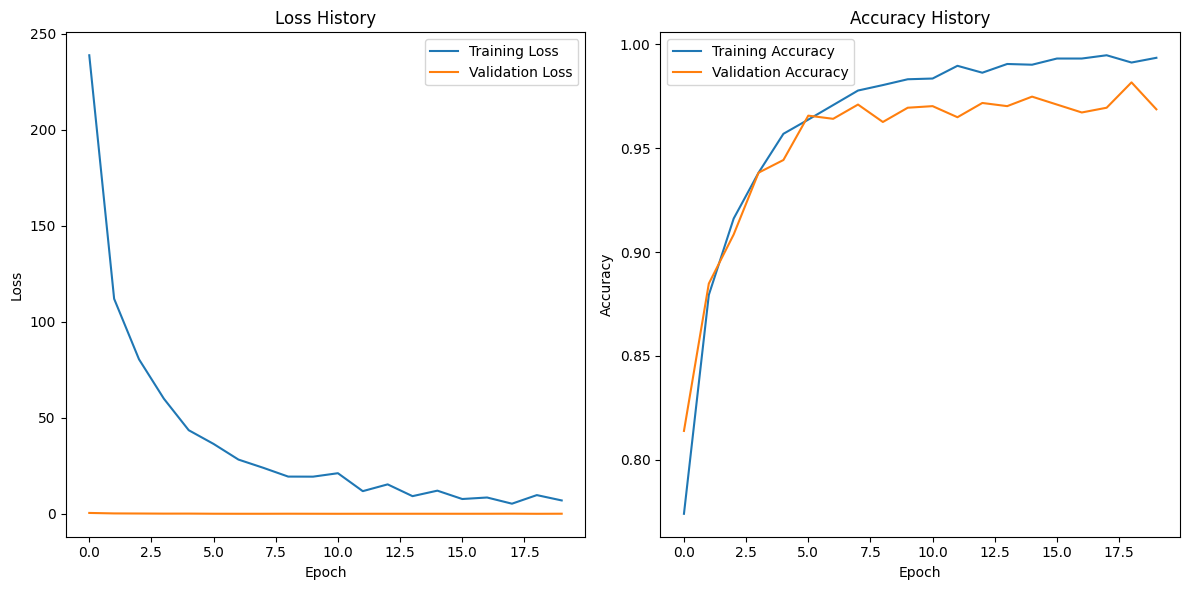

In [ ]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def highlight_tumor(image_path, predicted_mask=None, predicted_bbox=None, show_result=True):
    """
    Function to highlight the tumor area on a brain MRI image using a bounding box or segmentation mask.

    :param image_path: Path to the image file.
    :param predicted_mask: (Optional) Binary mask with tumor region (for segmentation).
    :param predicted_bbox: (Optional) Bounding box (x, y, w, h) for tumor area (for detection).
    :param show_result: If True, the image will be displayed with the tumor highlighted.
    :return: The final image with tumor highlighted.
    """

    # Read the MRI image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for visualization

    # If a predicted mask is provided, highlight the tumor area using the mask
    if predicted_mask is not None:
        # Assuming predicted_mask is a binary mask where tumor region is 1 (white)
        tumor_area = np.zeros_like(img_rgb)
        tumor_area[predicted_mask == 1] = [255, 0, 0]  # Highlight tumor in red (BGR format)
        img_rgb = cv2.addWeighted(img_rgb, 1, tumor_area, 0.5, 0)  # Blend the tumor region with original image

    # If a predicted bounding box is provided, highlight the tumor with a rectangle
    if predicted_bbox is not None:
        x, y, w, h = predicted_bbox
        cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (255, 0, 0), 3)  # Draw bounding box in red

    # Show the final image
    if show_result:
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()

    return img_rgb


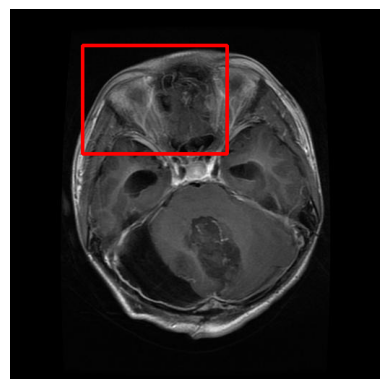

In [ ]:
# Sample bounding box (x, y, width, height)
predicted_bbox = (100, 50, 200, 150)  # Example bounding box values

# Path to the image (replace with your image path)
image_path = '/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/glioma/Te-glTr_0000.jpg'
# Call the function to highlight tumor area with bounding box
highlighted_image = highlight_tumor(image_path, predicted_bbox=predicted_bbox)


<ipython-input-56-8899ff0e21e0>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))  # Load the best model weights


The predicted class for the image is: glioma


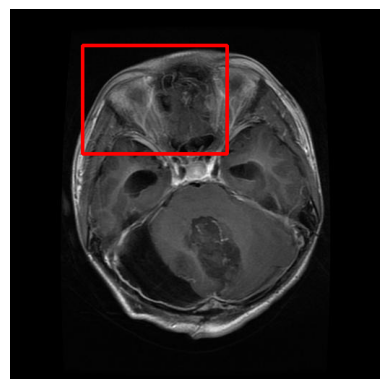

In [ ]:
import torch
import cv2
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

# Define the device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the saved model (ensure the same model architecture is used)
model = TumorClassifier(num_classes=4)
model.load_state_dict(torch.load('best_model.pth'))  # Load the best model weights
model.to(device)
model.eval()  # Set the model to evaluation mode

# Image preprocessing
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Define transformations
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),  # Resize to the model's expected input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Apply transformations to the image
    image_tensor = transform(image_rgb).unsqueeze(0).to(device)  # Add batch dimension
    return image_tensor

# Function to make predictions
def predict_tumor_class(image_path):
    # Preprocess the image
    image_tensor = preprocess_image(image_path)

    # Make predictions
    with torch.no_grad():
        output = model(image_tensor)  # Get the model's output
        _, predicted_class = torch.max(output, 1)  # Get the predicted class (index)

    # Map predicted class index to class name
    class_names = ['glioma', 'meningioma', 'pituitary', 'no_tumor']
    predicted_label = class_names[predicted_class.item()]

    return predicted_label

# Example usage
image_path = '/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/glioma/Te-glTr_0000.jpg'
predicted_class = predict_tumor_class(image_path)

print(f'The predicted class for the image is: {predicted_class}')

# Optionally: Show the image with tumor highlighted (bounding box or segmentation mask)
highlighted_image = highlight_tumor(image_path, predicted_bbox=(100, 50, 200, 150))  # You can adjust the bounding box as per your model's output


In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import torch
import cv2
import numpy as np
from torchvision import transforms
import gradio as gr
from PIL import Image
import matplotlib.pyplot as plt

# Define the device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the saved model (ensure the same model architecture is used)
model = TumorClassifier(num_classes=4)  # Ensure this matches your model architecture
model.load_state_dict(torch.load('best_model.pth'))  # Load the best model weights
model.to(device)
model.eval()  # Set the model to evaluation mode

# Image preprocessing function
def preprocess_image(image):
    # Convert to numpy array
    image = np.array(image)

    # Convert from RGB to BGR (OpenCV uses BGR format)
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Define transformations
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),  # Resize to the model's expected input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Apply transformations to the image
    image_tensor = transform(image_bgr).unsqueeze(0).to(device)  # Add batch dimension
    return image_tensor

# Function to make predictions
def predict_tumor_class(image):
    image_tensor = preprocess_image(image)

    with torch.no_grad():
        output = model(image_tensor)  # Get the model's output
        _, predicted_class = torch.max(output, 1)  # Get the predicted class (index)

    class_names = ['glioma', 'meningioma', 'pituitary', 'no_tumor']
    predicted_label = class_names[predicted_class.item()]

    return predicted_label

# Function to highlight tumor on the image (bounding box)
def highlight_tumor(image):
    img = np.array(image)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert to BGR for visualization

    # Example bounding box, adjust as necessary (for illustration purposes)
    predicted_bbox = (100, 50, 200, 150)  # Replace with actual model output
    x, y, w, h = predicted_bbox
    cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (255, 0, 0), 3)  # Draw bounding box in red

    # Convert to RGB for displaying in Gradio
    highlighted_image = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    return Image.fromarray(highlighted_image)

# Define the function that Gradio will use
def classify_and_highlight(image):
    predicted_class = predict_tumor_class(image)
    highlighted_image = highlight_tumor(image)
    return predicted_class, highlighted_image

# Create the Gradio interface (updated)
iface = gr.Interface(
    fn=classify_and_highlight,  # Function to run
    inputs=gr.Image(type="pil"),  # Input image (use PIL for compatibility)
    outputs=[gr.Textbox(label="Predicted Class"), gr.Image(label="Highlighted Image")],
    live=True,
    title="Brain Tumor Classifier",
    description="Upload a brain MRI image, and the model will classify the tumor type and highlight it with a bounding box."
)

# Launch the Gradio interface
iface.launch(share=True)


<ipython-input-62-654e45311da0>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))  # Load the best model weights


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://14587508289e0c98f7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
